<a href="https://colab.research.google.com/github/zach401/eEnergy_ACN-Sim_Abstract_Case_Study/blob/master/Example_EDF_vs_Uncontrolled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*If  running in a new enviroment, such as Google Colab, run this first.*

In [1]:
!git clone https://github.com/zach401/acnportal.git
!pip install acnportal/.

Cloning into 'acnportal'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (481/481), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 1186 (delta 260), reused 446 (delta 239), pack-reused 705
Receiving objects: 100% (1186/1186), 951.24 KiB | 1.65 MiB/s, done.
Resolving deltas: 100% (724/724), done.
Processing ./acnportal
  Stored in directory: /tmp/pip-ephem-wheel-cache-d29kabtc/wheels/6d/6a/19/10aef74a8c705c23f53e3e1d696420b07fcdbc88af47701336
Successfully built acnportal


# ACN-Sim Example
## Comparing EDF and Uncontrolled Charging
### by Zachary Lee
#### Last updated: 04/19/2019

In this example we implement a custom version of the Earliest Deadline First algorithm and compare it with Uncontrolled Charging. We show how easy it is to implement a custom algorithm using ACN-Sim as well as the simplicity of running a common experiment.

## Custom Algorithm

All custom algorithms inherit from the abstract class BaseAlgorithm. It is the responsibility of all derived classes to implement the schedule method. This method takes as an input a list of EVs which are currently connected to the system but have not yet finished charging. Its output is a dictionary which maps a station_id to a list of charging rates. Each charging rate is valid for one period measured relative to the current period.

For Example: 
 * schedule[‘abc’][0] is the charging rate for station ‘abc’ during the current period 
 * schedule[‘abc’][1] is the charging rate for the next period 
 * and so on. 

#### def __init__(self, increment=1):

We can override the __init__() method if we need to pass additional configuration information to the algorithm. In this case we pass in the increment which will be used when searching for a feasible rate.

#### schedule(self, active_evs)

We next need to override the schedule() method. The signature of this method should remain the same, as it is called internally in Simulator. If an algorithm needs additional parameters consider passing them through the constructor.

In [0]:
from acnportal.algorithms import BaseAlgorithm

class EarliestDeadlineFirstAlgo(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order or departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by departure time. We will then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}

        # Next, we sort the active_evs by their departure time.
        sorted_evs = sorted(active_evs, key=lambda x: x.departure)

        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [ev.max_rate]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

Note the structure of the schedule dict which is returned should be something like:

```
{
    'CA-301': [32, 32, 32, 16, 16, ..., 8],
    'CA-302': [8, 13, 13, 15, 6, ..., 0],
    ...,
    'CA-408': [24, 24, 24, 24, 0, ..., 0]
}
```
For the special case when an algorithm only calculates a target rate for the next time interval instead of an entire schedule of rates, the structure should be:

```
{
    'CA-301': [32],
    'CA-302': [8],
    ...,
    'CA-408': [24]
}
```

Note that these are single element lists and NOT floats or integers.

## Running the Algorithm

Now that we have implemented our algorithm, we can try it out. ACN-Sim provides useful utilities to make defining an experiment and running a simulation extremely simple. 

In [0]:
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='Set2')
from copy import deepcopy

from acnportal.algorithms import SortedSchedulingAlgo, UncontrolledCharging
from acnportal.algorithms import earliest_deadline_first
from acnportal.acnsim.events import acndata_events
from acnportal.acnsim.network.sites import CaltechACN
from acnportal.acnsim.analysis import *
from acnportal.acnsim import Simulator


# -- Experiment Parameters ---------------------------------------------------------------------------------------------
timezone = pytz.timezone('America/Los_Angeles')
start = datetime(2018, 9, 5).astimezone(timezone)
end = datetime(2018, 9, 6).astimezone(timezone)
period = 5  # minute
voltage = 220  # volts
max_rate = 32 # amps
site = 'caltech'

# -- Network -----------------------------------------------------------------------------------------------------------
cn = CaltechACN(basic_evse=True)

# -- Events ------------------------------------------------------------------------------------------------------------
API_KEY = 'DEMO_TOKEN'
events = acndata_events.generate_events(API_KEY, site, start, end, period, voltage, max_rate)


# -- Scheduling Algorithm ----------------------------------------------------------------------------------------------
schEDF = EarliestDeadlineFirstAlgo(increment=1)
schUC = UncontrolledCharging()

In [0]:
%%capture
# -- Simulator ---------------------------------------------------------------------------------------------------------
simEDF = Simulator(deepcopy(cn), schEDF, deepcopy(events), start, period=period, max_recomp=1)
simEDF.run()

In [0]:
%%capture
# For comparison we will also run the builtin UncontrolledCharging algorithm
simUC = Simulator(deepcopy(cn), schUC, deepcopy(events), start, period=period, max_recomp=1)
simUC.run()

## Results

We can now compare the two algorithms side by side by looking that the plots of aggregated current. 

We can see from this plot that UncontrolledCharging peaks before EDF and at a higher rate. This is because UncontrolledCharging does not factor in the constraints of infrastructure.

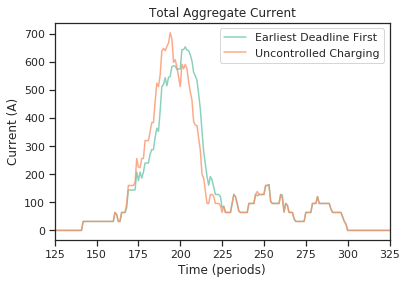

In [6]:
%matplotlib inline 
plt.plot(aggregate_current(simEDF), label='Earliest Deadline First', alpha=0.75)
plt.plot(aggregate_current(simUC), label='Uncontrolled Charging', alpha=0.75)
plt.xlim(125, 325)
plt.legend()
plt.xlabel('Time (periods)')
plt.ylabel('Current (A)')
plt.title('Total Aggregate Current')
plt.show()

To see this more clearly, we can example line currents in the three-phase system. Here we plot the line currents at the secondary side of the Caltech ACN transformer. We also include the current limit for these lines as a grey dashed line. We can see that in the uncontrolled case, the current in line A exceeds its limit, while in our EDF algorithm, all currents are below their limits. 

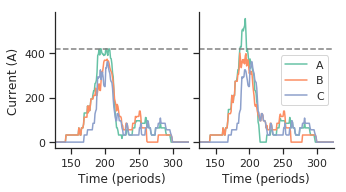

In [7]:
cc_EDF = constraint_currents(simEDF)
cc_UC = constraint_currents(simUC)

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(5,2.5))
fig.subplots_adjust(wspace=0.07)
axes[0].set_xlim(125, 325)

for line in 'ABC': 
  axes[0].plot(cc_EDF['Secondary {0}'.format(line)], label=line)
  axes[1].plot(cc_UC['Secondary {0}'.format(line)], label=line)

axes[0].axhline(420, color='gray', linestyle='--')
axes[1].axhline(420, color='gray', linestyle='--')
  
axes[1].legend()
axes[0].set_xlabel('Time (periods)')
axes[1].set_xlabel('Time (periods)')
axes[0].set_ylabel('Current (A)')
sns.despine()
plt.show()